In [1]:
import os
os.chdir("../")
print(os.getcwd())

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

C:\Users\ismae\Desktop\PhD_codes\TurbulentEncoderTransformerDecoder


In [18]:
nx, ny = 64, 64
T = 800
batch_size = 16
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# kolmo_flow_closure = "Data/Kolmogorov/processed_data/npyfiles/kolmo_closure.npy"
# kolmo_flow_filtered = "Data/Kolmogorov/processed_data/npyfiles/kolmo_filtered.npy"
# kolmo_flow_inference = "kolmo_f_inference_results.npy"
kolmo_flow_closure = "D:/data/Kolmogorov/kolmo_100s_8traj.npy"
kolmo_flow_filtered = "D:/data/Kolmogorov/kolmo_filtered_100s_8ens.npy"
kolmo_flow_inference = "D:/data/Kolmogorov/kolmo_filtered_200s_inference.npy"
traj = 7
Phi_f = np.load(kolmo_flow_filtered)[traj:traj+1, :, :]


Phi_closure = np.load(kolmo_flow_closure)[traj:traj+1, :, :]


Phi_inference = np.load(kolmo_flow_inference)[traj:traj+1, 1:, :]


print(Phi_f.shape, Phi_closure.shape, Phi_inference.shape)

(1, 800, 8192) (1, 800, 8192) (1, 801, 8192)


In [4]:
class TimeSplitDataset(Dataset):
    def __init__(self, filtered, closure):
        self.filtered = torch.tensor(filtered, dtype=torch.float32)
        self.closure = torch.tensor(closure, dtype=torch.float32)
        self.T = self.filtered.shape[1]

    def __len__(self):
        return self.T

    def __getitem__(self, idx):
        # return data at time idx: (channels, nx, ny)
        return self.filtered[:, idx, :], self.closure[:, idx, :]

T = Phi_f.shape[1]
    
split_idx = int(T * 0.8)  # 80% train, 20% test

filtered_train = Phi_f[:, :split_idx, :]   # shape (2, train_T, nx, ny)
filtered_test = Phi_f[:, split_idx:, :]    # shape (2, test_T, nx, ny)

closure_train = Phi_closure[:, :split_idx, :]
closure_test = Phi_closure[:, split_idx:, :]

train_dataset = TimeSplitDataset(filtered_train, closure_train)
test_dataset = TimeSplitDataset(filtered_test, closure_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
 
    def __init__(self, latent_size, input_size, model_eval):
        super(VAE, self).__init__()
 
        if not model_eval:
 
            self.e_fc1 = nn.Linear(input_size, 512)
            self.e_fc2 = nn.Linear(512, 256)
            self.e_fc3 = nn.Linear(256, 128)
            self.e_fc4 = nn.Linear(128, 64)
            self.e_fc5 = nn.Linear(64, latent_size)

            self.mu = nn.Linear(latent_size, latent_size)
            self.log_var = nn.Linear(latent_size, latent_size)
 
            self.d_fc1 = nn.Linear(latent_size, 64)
            self.d_fc2 = nn.Linear(64, 128)
            self.d_fc3 = nn.Linear(128, 256)
            self.d_fc4 = nn.Linear(256, 512)
            self.d_fc5 = nn.Linear(512, input_size)

            self.dropout = nn.Dropout(0.25)
            self.relu    = nn.ReLU()
 
    def encoder(self, x):
          
        x = self.relu(self.e_fc1(x))
        x = self.relu(self.e_fc2(x))
        x = self.relu(self.e_fc3(x))
        x = self.relu(self.e_fc4(x))
        x = self.e_fc5(x)
        
        return x
    
    def decoder(self, x):
 
        #non linear encoder
        x = self.relu(self.d_fc1(x))
        x = self.relu(self.d_fc2(x))
        x = self.relu(self.d_fc3(x))
        x = self.relu(self.d_fc4(x))
        x = self.d_fc5(x)
 
        return x

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
 
    def forward(self, Phi_n):
      
        encoded = self.encoder(Phi_n)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        x_n = self.reparameterize(mu, log_var)
        Phi_n_hat = self.decoder(x_n)
 
        return Phi_n_hat, mu, log_var
 
    def recover(self, x_n):
        
        Phi_n_hat = self.decoder(x_n)
        return Phi_n_hat

    def encode(self, Phi_n):

        encoded = self.encoder(Phi_n)
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        x_n = self.reparameterize(mu, log_var)

        return x_n, mu, log_var

In [6]:
latent_size = 6
input_size = Phi_f.shape[-1]
model = VAE(latent_size, input_size, model_eval = False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()

In [ ]:
epochs = 1000
beta_VAE = 0.01
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    total_loss = 0
    for filtered, closure in loop:

        filtered = filtered.to(device)  # [B,1,H,W]
        closure = closure.to(device)    # [B,1,H,W]

        recons, mu, logvar = model(filtered)
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse(recons, closure) + beta_VAE*KLD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=total_loss/(loop.n+1))

print("Training finished.")

Epoch 68:  50%|██████████████████████████████                              | 20/40 [00:00<00:00, 92.97it/s, loss=0.134]

Epoch 272: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.29it/s, loss=0.0214]


Epoch 340: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.87it/s, loss=0.0205]


Epoch 408: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.89it/s, loss=0.0196]


Epoch 476: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 40.27it/s, loss=0.0188]


Epoch 544: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.68it/s, loss=0.0183]


Epoch 612: 100%|█████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.98it/s, loss=0.018]


Epoch 680: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.71it/s, loss=0.0174]


Epoch 748: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.39it/s, loss=0.0169]


Epoch 816: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.54it/s, loss=0.0168]


Epoch 884: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.05it/s, loss=0.0163]


Epoch 952: 100%|████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.47it/s, loss=0.0162]


Epoch 1000: 100%|███████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.25it/s, loss=0.0161]

Training finished.


In [10]:
filtered_example = torch.tensor(filtered_test, dtype=torch.float32)
result = torch.tensor(closure_test, dtype=torch.float32)

ensemble_size = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)
model.eval()

_, T, D = closure_test.shape

Phi_hat_ens = torch.zeros((ensemble_size, T, D), dtype=torch.float32, device=device)

for n in tqdm(range(ensemble_size)):
    
    Phi_hat, mu, logvar = model(filtered_example.to(device))

    Phi_hat_ens[n, ...] = Phi_hat

    del Phi_hat
    torch.cuda.empty_cache()
    
Phi_hat_ens = Phi_hat_ens.detach().cpu().numpy()
print(Phi_hat_ens.shape)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.50it/s]

(15, 160, 8192)


In [11]:
from scipy.stats import norm
Phi_mean  = np.mean(Phi_hat_ens, axis = 0)
Phi_std  = np.std(Phi_hat_ens, axis = 0)
Phi_true = closure_test
# Compute metrics
rel_L1 = np.sum(np.abs(Phi_true - Phi_mean)) / np.sum(np.abs(Phi_true)) * 100
rel_L2 = np.sqrt(np.sum((Phi_true - Phi_mean)**2)) / np.sqrt(np.sum(Phi_true**2)) * 100

# Compute empirical percentiles for coverage
Phi_lower_sigma = Phi_mean - Phi_std
Phi_upper_sigma = Phi_mean + Phi_std
Phi_lower_3_sigma = Phi_mean - 3*Phi_std
Phi_upper_3_sigma = Phi_mean + 3*Phi_std

coverage_1_sigma = np.mean((Phi_true >= Phi_lower_sigma) & (Phi_true <= Phi_upper_sigma)) * 100
coverage_3_sigma = np.mean((Phi_true >= Phi_lower_3_sigma) & (Phi_true <= Phi_upper_3_sigma)) * 100

# CRPS computation (using the original method)
standardized = (Phi_true - Phi_mean) / Phi_std
crps_values = Phi_std * (1/np.sqrt(np.pi) - 2*norm.pdf(standardized) -
                          standardized * (2*norm.cdf(standardized) - 1))
crps = np.mean(crps_values)

print(f"  Relative L1 loss: {rel_L1:.2f}%")
print(f"  Relative L2 loss: {rel_L2:.2f}%")
print(f"  PICP (±1σ): {coverage_1_sigma:.2f}%")
print(f"  PICP (±3σ): {coverage_3_sigma:.2f}%")
print(f"  CRPS: {np.abs(crps):.4f}")

  Relative L1 loss: 20.34%
  Relative L2 loss: 22.77%
  PICP (±1σ): 19.34%
  PICP (±3σ): 52.22%
  CRPS: 0.1127


In [24]:
U_true.shape

(160, 64, 64)

In [26]:
T = 160
U_mean  = Phi_mean[:, :D//2]
V_mean  = Phi_mean[:, D//2:]
U_mean = U_mean.reshape(T, 64, 64)
V_mean = V_mean.reshape(T, 64, 64)

U_std  = Phi_std[:, :D//2]
V_std  = Phi_std[:, D//2:]
U_std = U_std.reshape(T, 64, 64)
V_std = V_std.reshape(T, 64, 64)

U_true  = Phi_true[0, :, :D//2]
V_true  = Phi_true[0, :, D//2:]
U_true = U_true.reshape(T, 64, 64)
V_true = V_true.reshape(T, 64, 64)

U_f  = Phi_f[0, -160:, :D//2]
V_f  = Phi_f[0, -160:, D//2:]
U_f = U_f.reshape(T, 64, 64)
V_f = V_f.reshape(T, 64, 64)

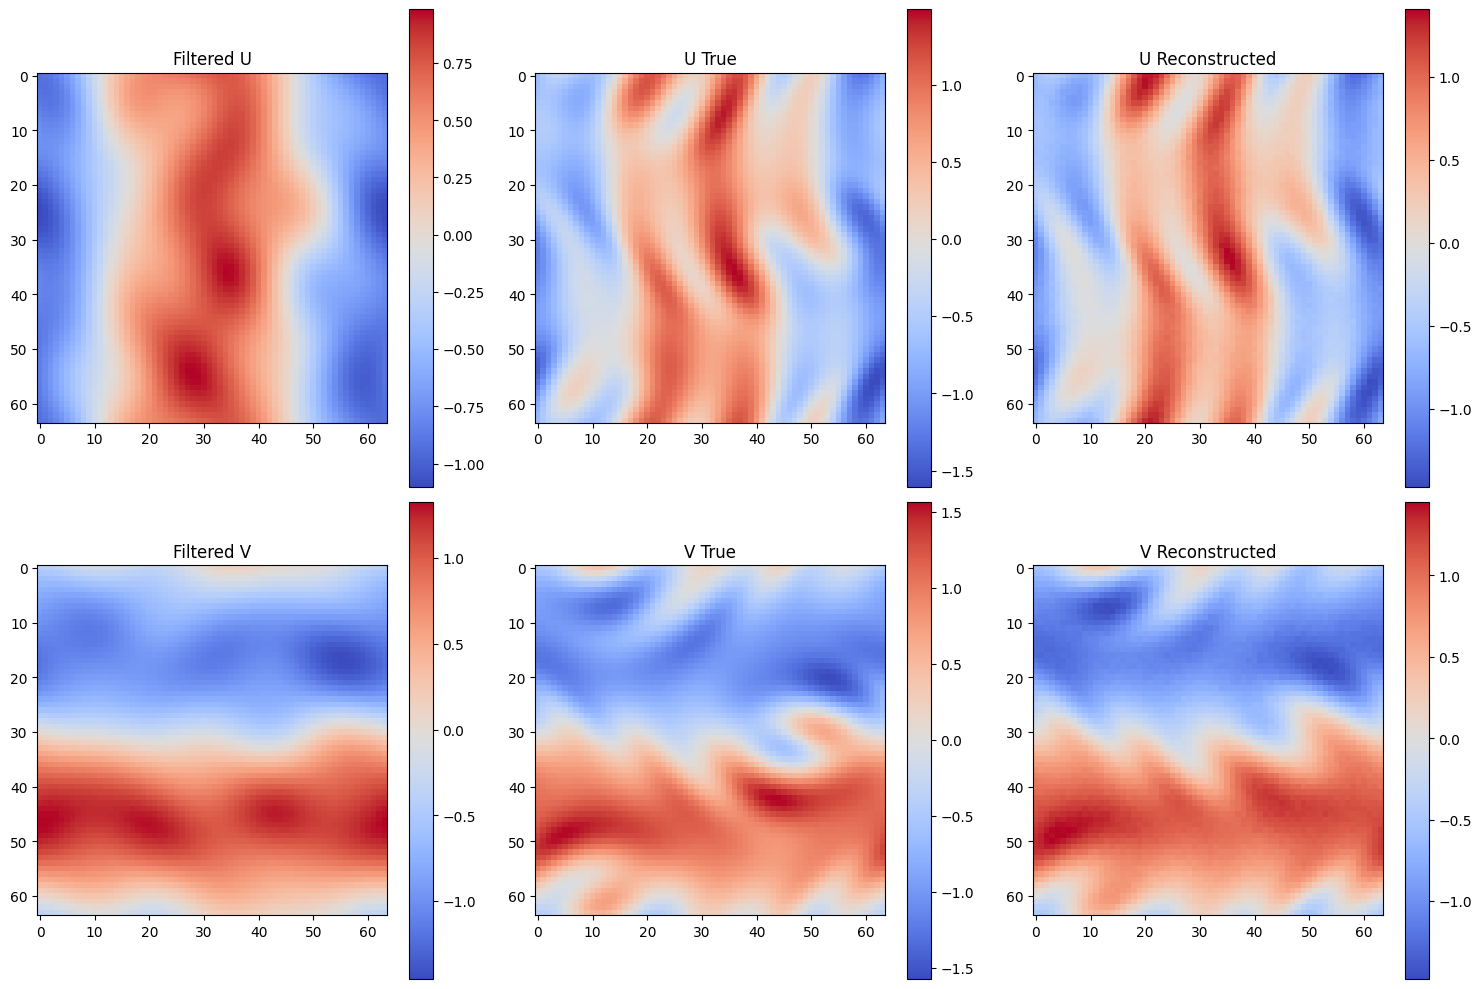

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

index = 120

plt.subplot(2, 3, 1)
plt.imshow(U_f[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('Filtered U')

plt.subplot(2, 3, 2)
plt.imshow(U_true[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('U True')

plt.subplot(2, 3, 3)
plt.imshow(U_mean[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('U Reconstructed')

plt.subplot(2, 3, 4)
plt.imshow(V_f[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('Filtered V')

plt.subplot(2, 3, 5)
plt.imshow(V_true[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('V True')

plt.subplot(2, 3, 6)
plt.imshow(V_mean[index,...], cmap='coolwarm')
plt.colorbar()
plt.title('V Reconstructed')


plt.tight_layout()
plt.show()

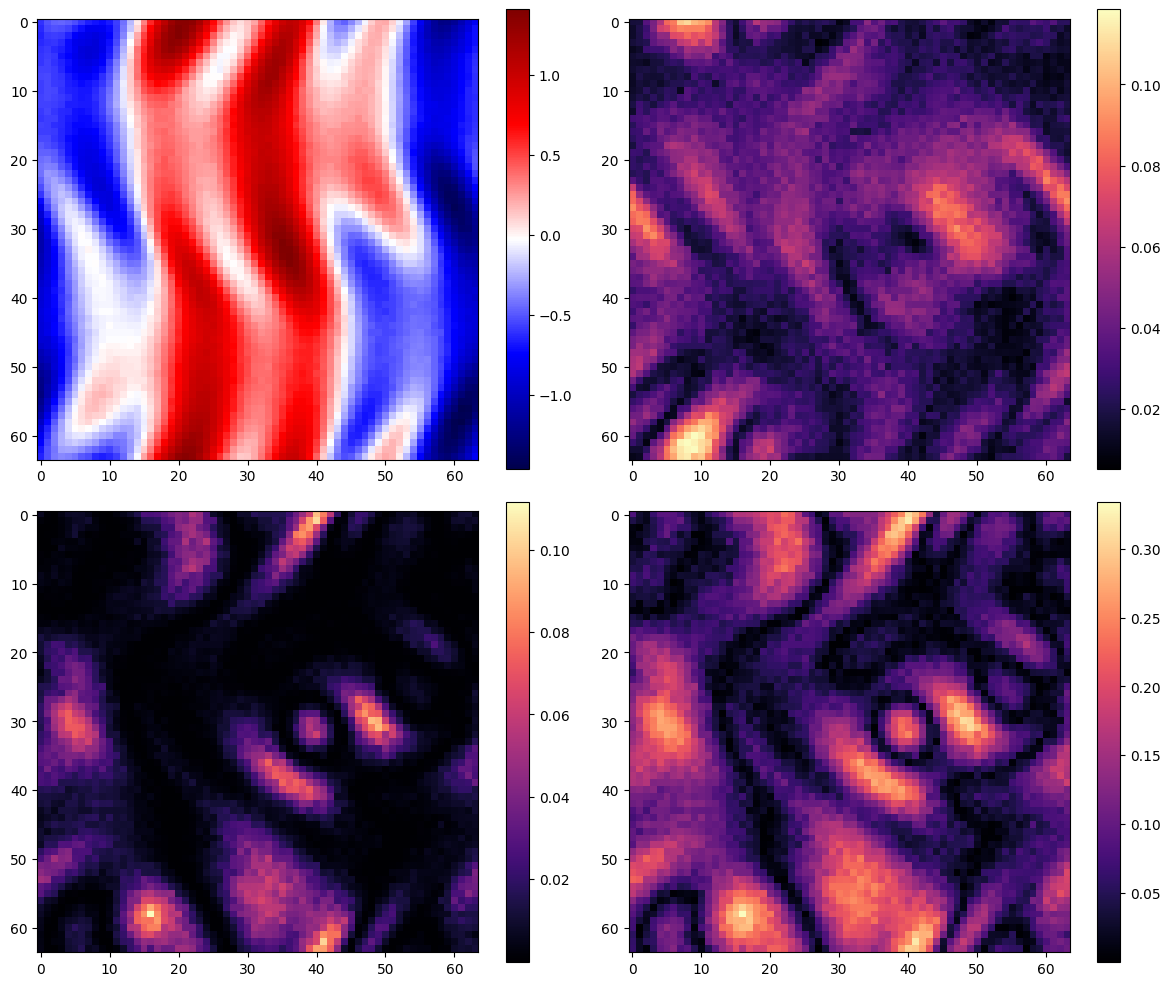

In [28]:
index = 120
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.imshow(U_mean[index,...], cmap='seismic')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(U_std[index,...], cmap='magma')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow((U_mean[index,...] - U_true[index,...])**2, cmap='magma')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(np.abs(U_mean[index,...] - U_true[index,...]), cmap='magma')
plt.colorbar()

plt.tight_layout()
plt.show()